In [1]:
import os
os.chdir('..')
print(os.getcwd())

from matplotlib import pyplot as plt
from dataset import JSRTDataset, TRAINING_SHAPES

/home/ron/Documents/DenseBone


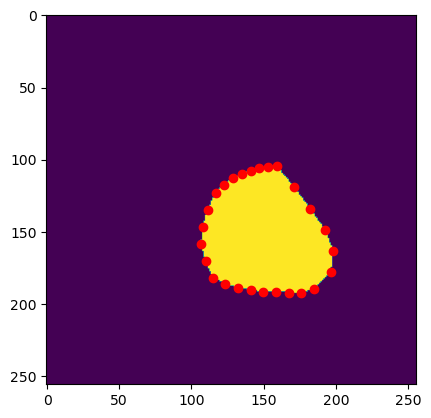

In [2]:
anatomy = 'heart'
anatomy_idx = JSRTDataset.get_anatomical_structure_index()[anatomy]
shapes = (TRAINING_SHAPES[:, anatomy_idx[0]:anatomy_idx[1]] + 1) / 2 * 256

_, _, _, _, seg_mask = JSRTDataset('train', return_seg_masks=True)[0]
anatomy_idx = list(JSRTDataset.get_anatomical_structure_index().keys()).index(anatomy)
seg_mask = seg_mask[anatomy_idx]

# extract bounding box of the segmentation mask
bb_idx = seg_mask.nonzero()
bb_min = bb_idx.min(0).values
bb_max = bb_idx.max(0).values
seg_bb = seg_mask[bb_min[0]:bb_max[0], bb_min[1]:bb_max[1]]

plt.imshow(seg_mask)
plt.scatter(shapes[0][:, 0], shapes[0][:, 1], c='r')

# Mean Shape

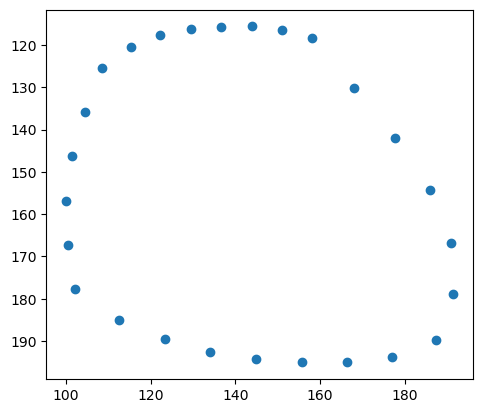

In [3]:
mean_shape = shapes.mean(0)
plt.scatter(mean_shape[:, 0], mean_shape[:, 1])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

# Prealignment

Prealigning Shapes: 100%|██████████| 160/160 [00:00<00:00, 8399.32it/s]


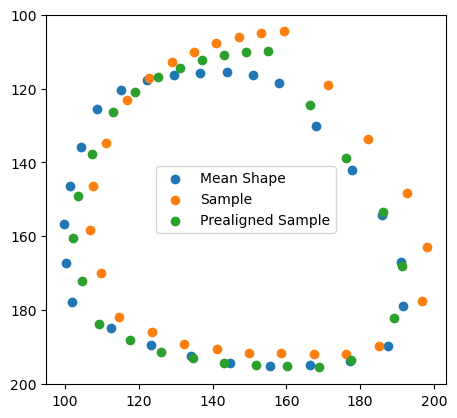

In [4]:
from utils import apply_umeyama_on_tensor
import tqdm
import torch

aligned_heart_shapes = torch.empty_like(shapes)
for i in tqdm.trange(len(shapes), desc='Prealigning Shapes'):
    aligned_heart_shapes[i] = apply_umeyama_on_tensor(shapes[i], mean_shape)

plt.scatter(mean_shape[:, 0], mean_shape[:, 1], label='Mean Shape')
plt.scatter(shapes[0][:, 0], shapes[0][:, 1], label='Sample')
plt.scatter(aligned_heart_shapes[0][:, 0], aligned_heart_shapes[0][:, 1], label='Prealigned Sample')
plt.legend()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

axis value ranges: tensor([1.0000, 0.8669]) tensor([-1.0000, -0.8669])


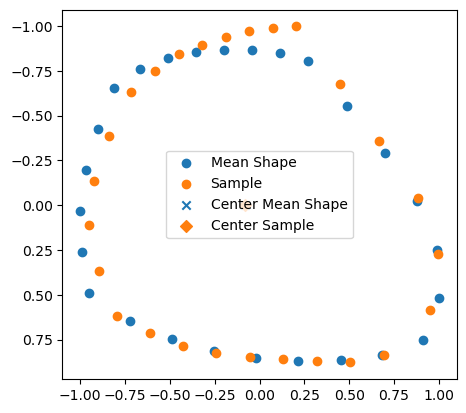

In [5]:
range_mean_shape =  mean_shape.max(0).values - mean_shape.min(0).values
mean_shape_norm = (mean_shape - mean_shape.min(0).values) / range_mean_shape.max()  # bigger axis [0, 1], smaller axis [0, <1]
mean_shape_norm = mean_shape_norm * 2 - (range_mean_shape / range_mean_shape.max()) # bigger axis [-1, 1], smaller axis [>-1, <1] (both centered around 0)
print('axis value ranges:', mean_shape_norm.max(0).values, mean_shape_norm.min(0).values)

heart_shapes_norm = (aligned_heart_shapes - mean_shape.min(0).values) / range_mean_shape.max()
heart_shapes_norm = heart_shapes_norm * 2 - (range_mean_shape / range_mean_shape.max())

plt.scatter(mean_shape_norm[:, 0], mean_shape_norm[:, 1], label='Mean Shape')
plt.scatter(heart_shapes_norm[0, :, 0], heart_shapes_norm[0, :, 1], label='Sample')
tmp1 = mean_shape_norm.mean(0)
tmp2 = heart_shapes_norm[0].mean(0)
plt.scatter(tmp1[0], tmp1[1], label='Center Mean Shape', marker='x', c='tab:blue')
plt.scatter(tmp2[0], tmp2[1], label='Center Sample', marker='D', c='tab:orange')
plt.legend()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

del tmp1, tmp2

# Registration

In [6]:
import torch

fixed_pc = heart_shapes_norm[0]
atlas_pc = mean_shape_norm

displacements = fixed_pc - atlas_pc
warped_atlas_pc = atlas_pc + displacements

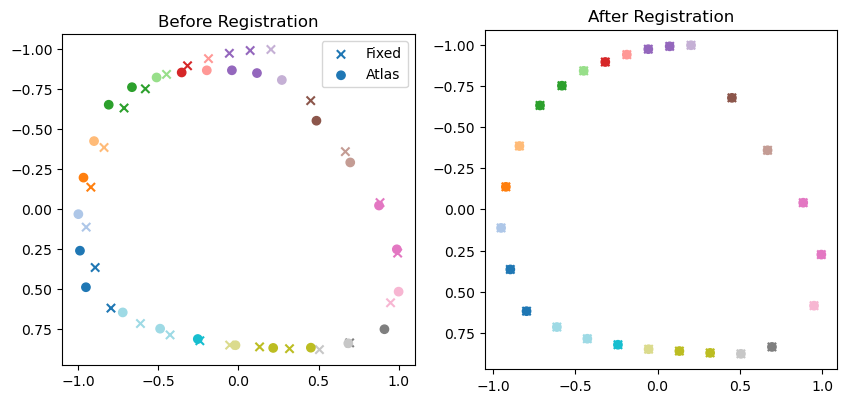

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
n = len(fixed_pc)
ax[0].scatter(fixed_pc[:, 0], fixed_pc[:, 1], c=torch.arange(n), cmap='tab20', marker='x', label='Fixed')
ax[0].scatter(atlas_pc[:, 0], atlas_pc[:, 1], c=torch.arange(n), cmap='tab20', marker='o', label='Atlas')
ax[0].set_title('Before Registration')
ax[0].legend()
ax[0].invert_yaxis()
ax[0].set_aspect('equal')

ax[1].scatter(fixed_pc[:, 0], fixed_pc[:, 1], c=torch.arange(n), cmap='tab20', marker='x')
ax[1].scatter(warped_atlas_pc[:, 0], warped_atlas_pc[:, 1], c=torch.arange(n), cmap='tab20', marker='o')
ax[1].set_title('After Registration')
ax[1].invert_yaxis()
ax[1].set_aspect('equal')

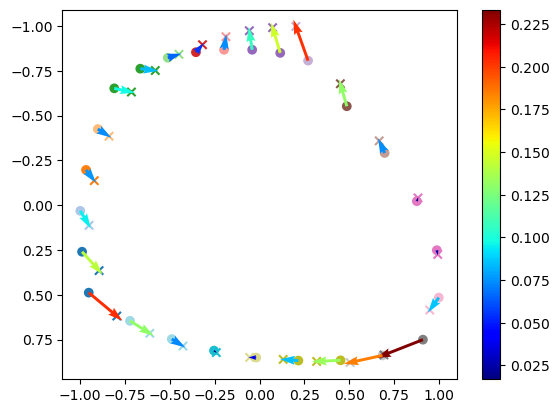

In [8]:
magnitude = torch.norm(displacements, dim=-1)

# plot the displacement field
plt.scatter(atlas_pc[:, 0], atlas_pc[:, 1], c=torch.arange(n), cmap='tab20', marker='o')
plt.scatter(warped_atlas_pc[:, 0], warped_atlas_pc[:, 1], c=torch.arange(n), cmap='tab20', marker='x')
plt.quiver(atlas_pc[:, 0], atlas_pc[:, 1], displacements[:, 0], -displacements[:, 1], magnitude, cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

# Interpolation of Displacement Field

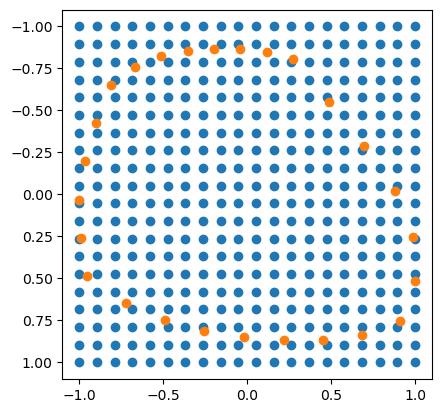

In [9]:
grid = torch.meshgrid(torch.linspace(-1, 1, 20), torch.linspace(-1, 1, 20), indexing='ij')
grid = torch.stack(grid, dim=-1).reshape(-1, 2)

plt.scatter(grid[:, 0], grid[:, 1])
plt.scatter(atlas_pc[:, 0], atlas_pc[:, 1])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

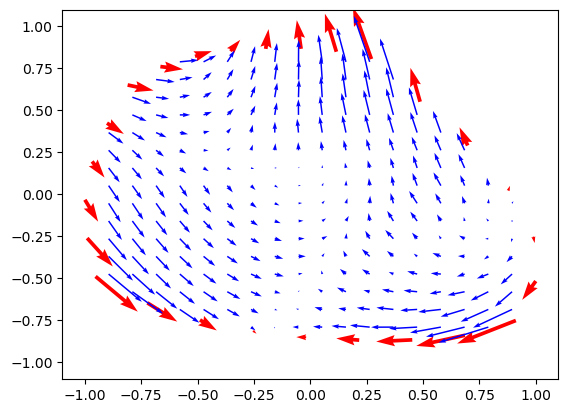

In [10]:
from scipy.interpolate import griddata

grid_displacements = griddata(atlas_pc, displacements, grid, method='linear', rescale=True)
plt.quiver(atlas_pc[:, 0], -atlas_pc[:, 1], displacements[:, 0], -displacements[:, 1], color='r')
plt.quiver(grid[:, 0], -grid[:, 1], grid_displacements[:, 0], -grid_displacements[:, 1], color='b')
# plt.gca().invert_yaxis()
# plt.gca().set_aspect('equal')

# Grid Map

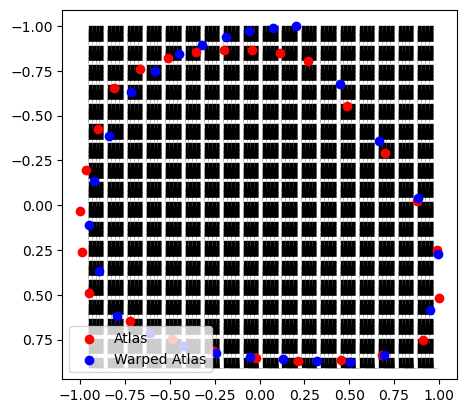

In [11]:
# calculate how many pixel are needed to represent the shape with same resolution as the atlas
n_pixel_per_unit = max(range_mean_shape) / 2
x_n_pixel, y_n_pixel = seg_bb.shape[::-1]

# values of the grid
grid_img = torch.zeros(x_n_pixel, y_n_pixel)
grid_img[::5, :] = 1
grid_img[:, ::5] = 1

# grid coordinates
grid_coord = torch.meshgrid(
    torch.linspace(warped_atlas_pc[:, 0].min(), warped_atlas_pc[:, 0].max(), x_n_pixel),
    torch.linspace(warped_atlas_pc[:, 1].min(), warped_atlas_pc[:, 1].max(), y_n_pixel),
    indexing='ij'
)
grid_coord = torch.stack(grid_coord, dim=-1)

plt.scatter(grid_coord[..., 0].reshape(-1), grid_coord[..., 1].reshape(-1), c=grid_img.reshape(-1), cmap='gray', marker=',')
plt.scatter(atlas_pc[:, 0], atlas_pc[:, 1], c='r', label='Atlas')
plt.scatter(warped_atlas_pc[:, 0], warped_atlas_pc[:, 1], c='b', label='Warped Atlas')
plt.legend()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

In [12]:
# interpolate the displacement field for each grid point
grid_displacements = griddata(warped_atlas_pc, displacements, grid_coord, method='linear', rescale=True)
grid_displacements = torch.from_numpy(grid_displacements).float()

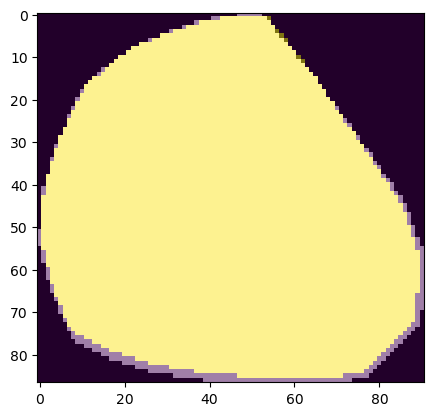

In [13]:
# miss alignment is caused by the interpolation
plt.imshow(grid_displacements.isnan().all(-1).logical_not().T)
plt.imshow(seg_bb, 'gray', alpha=.5)

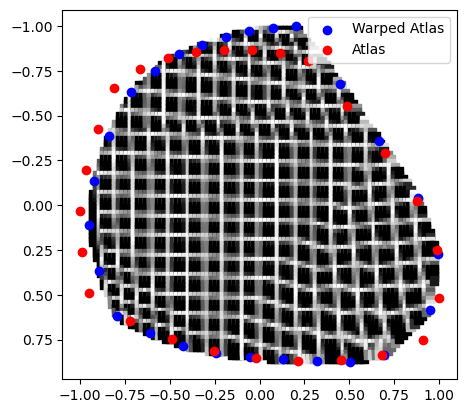

In [14]:
# warp the grid image

from torch.nn import functional as F

cloned_grid_displacements = grid_displacements.clone()
cloned_grid_displacements[...,1] *= -1

identity_grid = F.affine_grid(torch.eye(2, 3).unsqueeze(0), [1, 1, *grid_img.shape], align_corners=True)
# grid = identity_grid + grid_displacements.unsqueeze(0)
grid = identity_grid + cloned_grid_displacements.unsqueeze(0)

warped_grid_img = F.grid_sample(grid_img.unsqueeze(0).unsqueeze(0), grid, mode='bilinear', align_corners=True)
warped_grid_img = warped_grid_img.squeeze(0).squeeze(0)

plt.scatter(grid_coord[..., 0].reshape(-1), grid_coord[..., 1].reshape(-1), c=warped_grid_img.reshape(-1), cmap='gray', marker=',')
plt.scatter(warped_atlas_pc[:, 0], warped_atlas_pc[:, 1], c='b', label='Warped Atlas')
plt.scatter(atlas_pc[:, 0], atlas_pc[:, 1], c='r', label='Atlas')
plt.legend()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

# UV Map

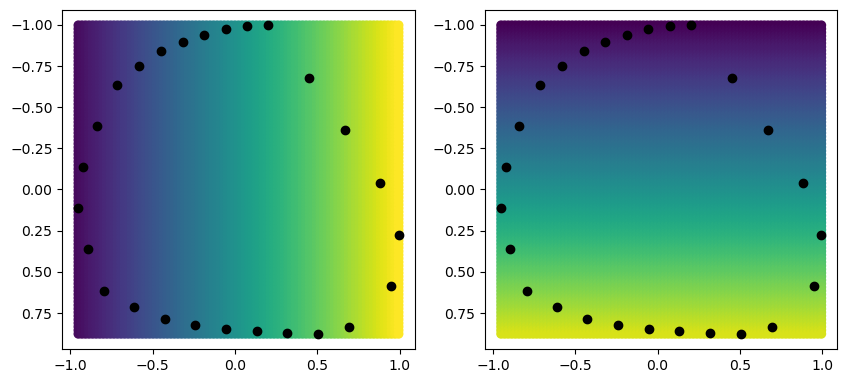

In [15]:
# same as above but for uv coordinates
uv = torch.meshgrid(
    torch.linspace(warped_atlas_pc[:, 0].min(), warped_atlas_pc[:, 0].max(), x_n_pixel),
    torch.linspace(warped_atlas_pc[:, 1].min(), warped_atlas_pc[:, 1].max(), y_n_pixel),
    indexing='ij'
)
uv = torch.stack(uv, dim=-1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(grid_coord[..., 0].reshape(-1), grid_coord[..., 1].reshape(-1), c=uv[..., 0].reshape(-1), cmap='viridis', vmax=1, vmin=-1)
ax[0].scatter(warped_atlas_pc[:, 0], warped_atlas_pc[:, 1], c='k')
ax[0].invert_yaxis()
ax[0].set_aspect('equal')

ax[1].scatter(grid_coord[..., 0].reshape(-1), grid_coord[..., 1].reshape(-1), c=uv[...,1].reshape(-1), cmap='viridis', vmax=1, vmin=-1)
ax[1].scatter(warped_atlas_pc[:, 0], warped_atlas_pc[:, 1], c='k')
ax[1].invert_yaxis()
ax[1].set_aspect('equal')

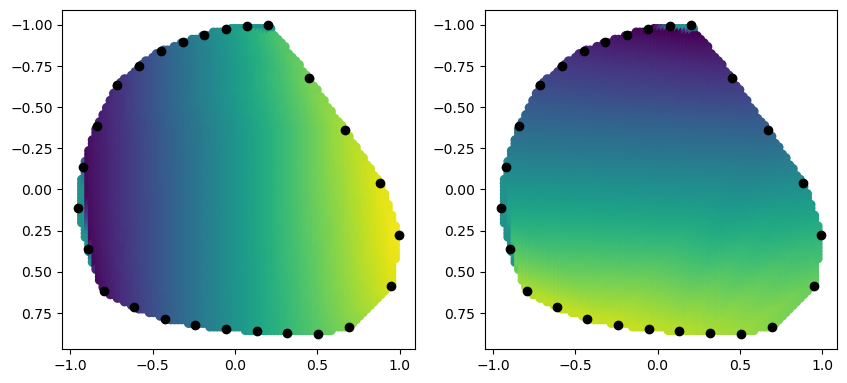

In [16]:
warped_uv = F.grid_sample(uv.permute(2, 0, 1).unsqueeze(0), grid, mode='bilinear', align_corners=True)
warped_uv = warped_uv.squeeze(0).permute(1, 2, 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(grid_coord[..., 0].reshape(-1), grid_coord[..., 1].reshape(-1), c=warped_uv[..., 0].reshape(-1), cmap='viridis', vmax=1, vmin=-1)
ax[0].scatter(warped_atlas_pc[:, 0], warped_atlas_pc[:, 1], c='k')
ax[0].invert_yaxis()
ax[0].set_aspect('equal')

ax[1].scatter(grid_coord[..., 0].reshape(-1), grid_coord[..., 1].reshape(-1), c=warped_uv[...,1].reshape(-1), cmap='viridis', vmax=1, vmin=-1)
ax[1].scatter(warped_atlas_pc[:, 0], warped_atlas_pc[:, 1], c='k')
ax[1].invert_yaxis()
ax[1].set_aspect('equal')

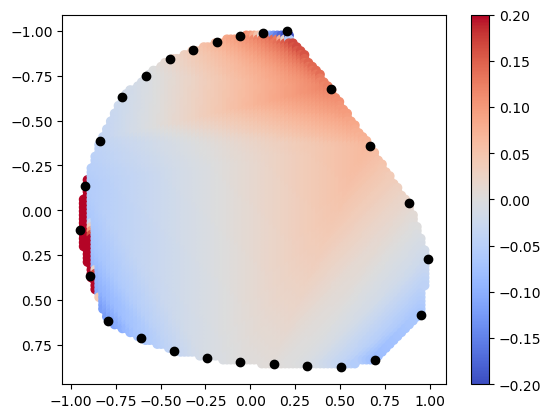

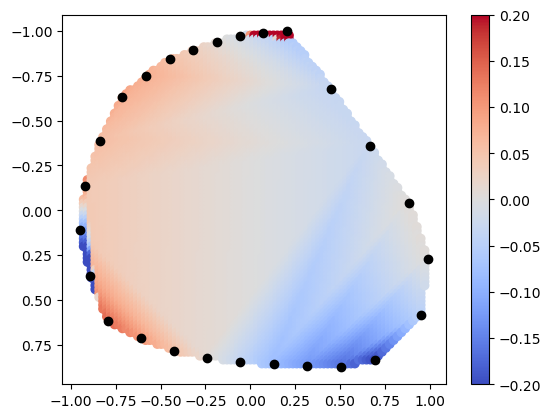

In [17]:
# plot the difference between the warped uv and the original uv

diff = warped_uv - uv
diff = diff.clamp(-.2,  +.2)

plt.scatter(grid_coord[..., 0].reshape(-1), grid_coord[..., 1].reshape(-1), c=diff[..., 0].view(-1), cmap='coolwarm')
plt.colorbar()
plt.scatter(warped_atlas_pc[:, 0], warped_atlas_pc[:, 1], c='k')
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

plt.figure()
plt.scatter(grid_coord[..., 0].reshape(-1), grid_coord[..., 1].reshape(-1), c=diff[..., 1].view(-1), cmap='coolwarm')
plt.colorbar()
plt.scatter(warped_atlas_pc[:, 0], warped_atlas_pc[:, 1], c='k')
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

# Alignment of Segmentation Masks

Text(0.5, 1.0, 'Bounding Box Segmentation Mask')

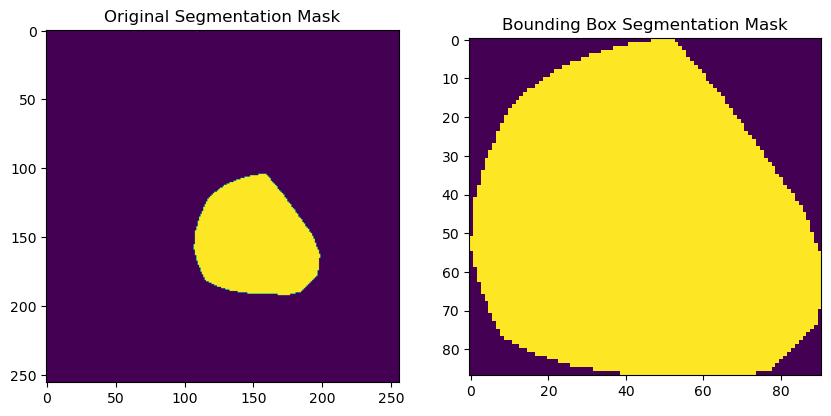

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(seg_mask)
axs[0].set_title('Original Segmentation Mask')
axs[1].imshow(seg_bb)
axs[1].set_title('Bounding Box Segmentation Mask')

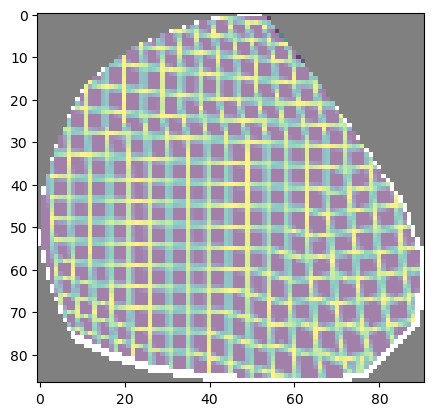

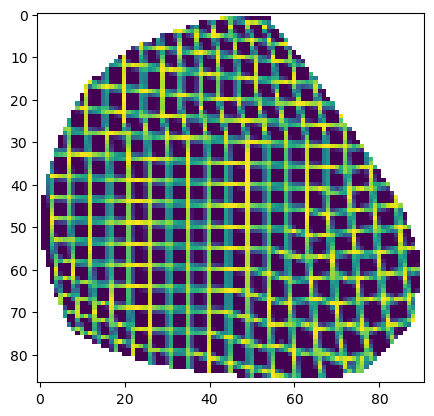

In [19]:
plt.imshow(seg_bb, 'gray', alpha=.5)
plt.imshow(warped_grid_img.T, alpha=.5)

plt.figure()
plt.imshow(warped_grid_img.T)